Here, we test code specifically for accurately measuring the radii of random directions for a known 2d loss landscape.

# Baseline

First, code for the baseline 2D loss landscape. We require a loss landscape and a model.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List

class LossLandscape:
    def __init__(self, 
                 minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2,
                 amplitude=1.0,
                 baseline=1.0):
        """
        Initialize a customizable loss landscape with two minima.
        """
        self.minima_sharp_loc = minima_sharp_loc
        self.minima_wide_loc = minima_wide_loc
        self.sharp_width = sharp_width
        self.wide_width = wide_width
        self.amplitude = amplitude
        self.baseline = baseline
        
    def get_minima_parameters(self):
        """Return the key parameters defining the minima"""
        return {
            'minima_sharp_loc': self.minima_sharp_loc,
            'minima_wide_loc': self.minima_wide_loc,
            'sharp_width': self.sharp_width,
            'wide_width': self.wide_width
        }
        
    def __call__(self, x):
        """Compute the loss at point(s) x"""
        gaussian_sharp = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_sharp_loc) / self.sharp_width)**2
        )
        gaussian_wide = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_wide_loc) / self.wide_width)**2
        )
        return self.baseline - gaussian_sharp - gaussian_wide
    
    def visualize(self, x_range=(-2, 2), num_points=500):
        """Visualize the loss landscape"""
        x = torch.linspace(x_range[0], x_range[1], num_points)
        loss = self(x)
        
        plt.figure(figsize=(8, 5))
        plt.plot(x.numpy(), loss.numpy())
        plt.xlabel('x')
        plt.ylabel('Loss')
        plt.title('Loss Landscape')
        
        plt.axvline(x=self.minima_sharp_loc, color='r', 
                   linestyle='--', alpha=0.3, label='Sharp minimum')
        plt.axvline(x=self.minima_wide_loc, color='b', 
                   linestyle='--', alpha=0.3, label='Wide minimum')
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    def random_parameter_search(self, dim: int, num_samples: int = 10000, upper = 10, low = -10):
        """
        Perform random parameter search using the class's minima parameters
        
        Args:
            dim: Dimension of parameter space
            num_samples: Number of random samples to generate
            
        Returns:
            Tuple of (sharp_count, wide_count, samples)
        """
        minima_sharp_count = 0
        minima_wide_count = 0
        samples = []
        
        for _ in range(num_samples):
            params = np.random.uniform(low=low, high=upper, size=dim)
            product = np.prod(params)
            samples.append(product)
            
            if abs(product - self.minima_sharp_loc) < self.sharp_width:
                minima_sharp_count += 1
            if abs(product - self.minima_wide_loc) < self.wide_width:
                minima_wide_count += 1
        
        return minima_sharp_count, minima_wide_count, samples
        
class NParameterModel(torch.nn.Module):
    def __init__(self, initial_values: List[float]):
        super().__init__()
        # Create N parameters from the initial values
        self.params = torch.nn.ParameterList([
            torch.nn.Parameter(torch.tensor([val], dtype=torch.float32))
            for val in initial_values
        ])
    
    def forward(self):
        # Compute product of all parameters
        x = torch.prod(torch.stack([p for p in self.params]))
        return x

    def get_parameter_values(self):
        return [p.item() for p in self.params]

Our perturbation functions we grab from perturb_simple.py. The ones we need are the ability to generate random directions, wiggle_multiple_directions to wiggle in the random directions, and loss_threshold_crossing to find how far it takes for them to cross a loss threshold of interest.

We also import useful visualization functions

In [2]:
# Importing our existing funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from perturb_simple import (
    generate_random_perturbations,
    wiggle_multiple_directions,
    loss_threshold_crossing,
)

from visualize_2d import (
    plot_parameter_space_with_arrows,
    plot_parameter_space_with_polygon,
)

## In our case, we might also use a generate circular perturbations a lot
def generate_circular_perturbations(num_vectors):
    """
    Generate evenly spaced unit vectors around a circle using only PyTorch.
    """
    angles = torch.linspace(0, 2 * torch.pi, num_vectors + 1)[:-1]  # Evenly spaced, exclude duplicate 2π
    x = torch.cos(angles)
    y = torch.sin(angles)
    
    return [
        {'params.0': x[i].reshape(1), 'params.1': y[i].reshape(1)} 
        for i in range(num_vectors)
    ]

For expected r^n, we have 

In [3]:
"""
rn_values = [r**dimension for r in r_values]
volume = sum(rn_values) / len(rn_values)
all_volumes[model_idx][perturb_idx] = volume
print(f"    Computed volume: {volume:.4f}")"""

'\nrn_values = [r**dimension for r in r_values]\nvolume = sum(rn_values) / len(rn_values)\nall_volumes[model_idx][perturb_idx] = volume\nprint(f"    Computed volume: {volume:.4f}")'

Generate a loss landscape, a model, the circular directions, and evaluate their radii:

In [4]:
# Initialize our loss landscape
minima_sharp_loc=-1.0, 
minima_wide_loc=1.0,
sharp_width=0.1,
wide_width=0.2
loss_fn = LossLandscape(minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2)

# Model
scale = 1.0
model_example = NParameterModel([scale, 1/scale])

# Generate perturbation directions
num_perturb_directions = 10
perturb_vectors = generate_circular_perturbations(num_perturb_directions)

# Coefficients to sample
N = 101
coefficients = np.linspace(0, 2, N)

# The loss is 1 - gaussian_sharp, which is 0.3935
loss_threshold = 0.3935

In [5]:
results = wiggle_multiple_directions(model = model_example, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients, verbose =True)

r_values, valid_directions = loss_threshold_crossing(results, loss_threshold = loss_threshold)

Evaluating direction 1/10...
Evaluating direction 2/10...
Evaluating direction 3/10...
Evaluating direction 4/10...
Evaluating direction 5/10...
Evaluating direction 6/10...
Evaluating direction 7/10...
Evaluating direction 8/10...
Evaluating direction 9/10...
Evaluating direction 10/10...


We can print out the list of radius values, or plot it using our good visualization code.

[0.2, 0.12, 0.14, 0.36, 0.44, 0.2, 0.14, 0.16, 0.26, 0.92]
Wide loc  1.0


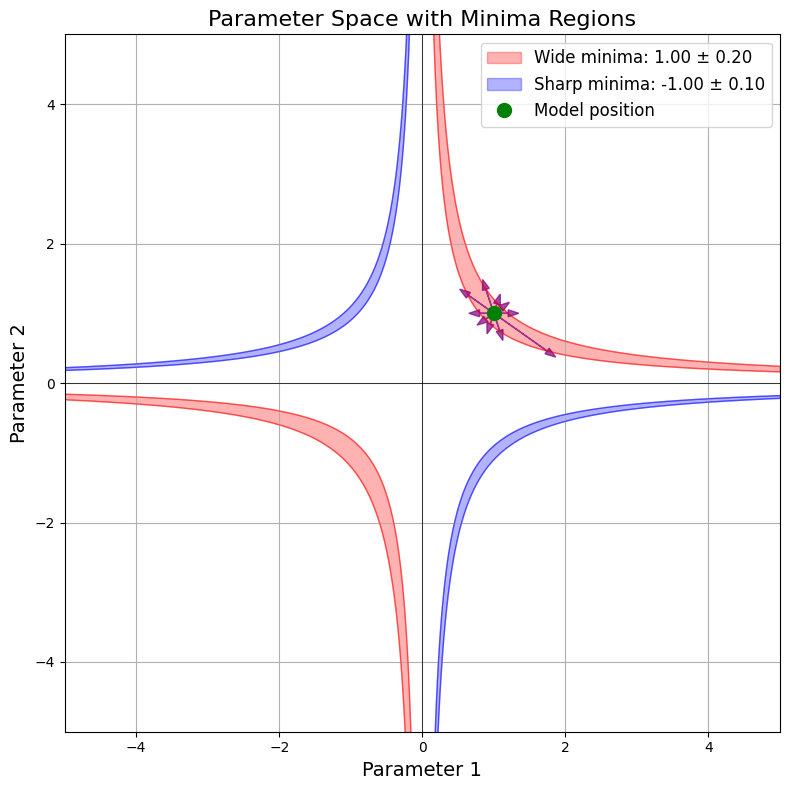

In [6]:
print (r_values)

plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model_example,
    perturbation_directions=perturb_vectors,
    r_values=r_values,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

Recall our code generates vectors counter clockwise starting from the horizontal. Next, we develop code to estimate the exact radii, since we have a point and know the exact functional form of our borders (given by $x, (a \pm w)/x$.

In [7]:
# This is code that determines the exact distance from the source point to the edges of the curves
def find_r(x, y, a, w, vx, vy):
    """
    Compute the smallest positive r such that (x + r*vx, y + r*vy)
    intersects either curve y = (a ± w)/x.
    """
    def solve_quadratic(A, B, C):
        # Handle near-zero A (linear case)
        if abs(A) < 1e-12:
            if abs(B) < 1e-12:
                return None
            r = -C / B
            return r if r > 0 else None

        D = B**2 - 4 * A * C
        if D < 0:
            return None

        sqrt_D = np.sqrt(D)
        r1 = (-B + sqrt_D) / (2 * A)
        r2 = (-B - sqrt_D) / (2 * A)

        positive_roots = [r for r in (r1, r2) if r > 0]
        return min(positive_roots) if positive_roots else None

    # Try both boundaries: a + w and a - w
    r_candidates = []
    for delta in [+w, -w]:
        A = vx * vy
        B = x * vy + y * vx
        C = x * y - (a + delta)

        r = solve_quadratic(A, B, C)
        if r is not None:
            r_candidates.append(r)

    return min(r_candidates) if r_candidates else None

# A wrapper that processes a list of perturbation vectors
def compute_r_list(origin, a, w, perturb_vectors):
    x, y = origin
    r_list = []

    for vec in perturb_vectors:
        vx = vec['params.0'].item()
        vy = vec['params.1'].item()
        r = find_r(x, y, a, w, vx, vy)
        r_list.append(r)

    return r_list

Example usage for a single vector

In [8]:
# Grab our model position
origin = model_example.get_parameter_values()

# The minima and the width
a = minima_wide_loc[0]
w = wide_width

## The vector 
vx = perturb_vectors[0]['params.0'].item()
vy = perturb_vectors[0]['params.1'].item()
print (origin[0], ' origin pts ', origin[1])
print (a, ' and w ', w)
print (vx, ' vector ', vy)

r_value_exact = find_r(origin[0], origin[1], a, w, vx, vy)
print (r_value_exact)

1.0  origin pts  1.0
1.0  and w  0.2
1.0  vector  0.0
0.19999999999999996


Usage on the list of vectors, and comparison with the original approximate method.

In [9]:
r_values_exact = compute_r_list(origin, a, w, perturb_vectors)
print (r_values_exact)
print (r_values)

[0.19999999999999996, 0.13681198677403222, 0.15324370502057003, 0.37633861711097893, 0.4563646194490658, 0.19999998653856063, 0.1509404517980178, 0.16507659882679526, 0.2765091433273989, 0.9215992067735388]
[0.2, 0.12, 0.14, 0.36, 0.44, 0.2, 0.14, 0.16, 0.26, 0.92]


Wide loc  1.0


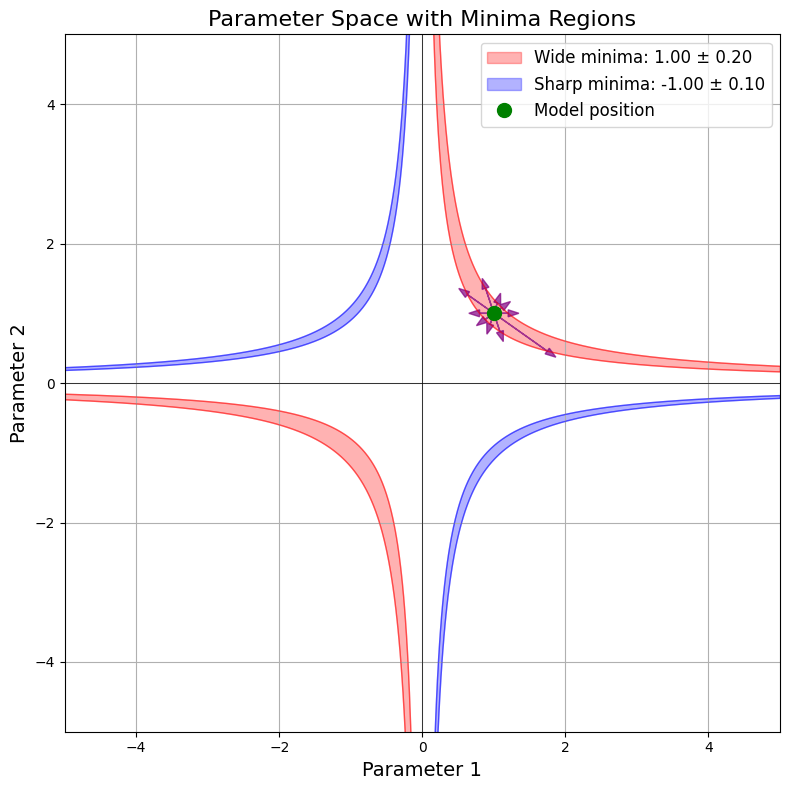

In [10]:
plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model_example,
    perturbation_directions=perturb_vectors,
    r_values=r_values_exact,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

As an extra point of comparison (to verify our loss landscape based function is correct) is to multiply these r values by the vector, add it to the model origin, and check how far they differ from the exact values for the curve.

In [11]:
for i, r in enumerate(r_values_exact):
    print(f"Index {i}:")
    exact_x = origin[0] + r_values_exact[i]*perturb_vectors[i]['params.0'].item()
    exact_y = origin[1] + r_values_exact[i]*perturb_vectors[i]['params.1'].item()
    numeric_x = origin[0] + r_values[i]*perturb_vectors[i]['params.0'].item()
    numeric_y = origin[1] + r_values[i]*perturb_vectors[i]['params.1'].item()

    print ("Exact radius gives ",(exact_x, exact_y), " compared to theoretical value for this x with y ", ((a + w)/exact_x, (a - w)/exact_x))
    print ("Numeric radius gives ",(numeric_x, numeric_y), " compared to theoretical value for this x with y ", ((a + w)/numeric_x, (a - w)/numeric_x))
    print ("The exact radius was ", r_values_exact[i] , " compared to the numeric radius ", r_values[i])


Index 0:
Exact radius gives  (1.2, 1.0)  compared to theoretical value for this x with y  (1.0, 0.6666666666666667)
Numeric radius gives  (1.2, 1.0)  compared to theoretical value for this x with y  (1.0, 0.6666666666666667)
The exact radius was  0.19999999999999996  compared to the numeric radius  0.2
Index 1:
Exact radius gives  (1.110683223457291, 1.0804160670264626)  compared to theoretical value for this x with y  (1.0804160670264624, 0.7202773780176418)
Numeric radius gives  (1.097082040309906, 1.0705342292785645)  compared to theoretical value for this x with y  (1.093810632121023, 0.7292070880806821)
The exact radius was  0.13681198677403222  compared to the numeric radius  0.12
Index 2:
Exact radius gives  (1.0473549058230827, 1.145743427875538)  compared to theoretical value for this x with y  (1.1457434278755378, 0.7638289519170254)
Numeric radius gives  (1.043262376189232, 1.1331479156017303)  compared to theoretical value for this x with y  (1.1502379721420513, 0.766825314

The numeric radius algorithm is fairly close to the exact radii here. As we would expect, the numeric algorithm is hampered by the resolution we use in calculating the radius, and always underestimates the actual radius (which is to be expected).

Since these match quite closely, it seems we can proceed with testing the volumes against the analytical solution.

# Large Scale Volume Tests

As a final test, we can run two experiments with a large number of vectors.

In [19]:
import random
def compute_sampled_volume(r_values, K, dimension):
    # Select K random elements (without replacement)
    sampled_r = random.sample(r_values, K)
    rn_values = [r ** dimension for r in sampled_r]
    volume = sum(rn_values) / len(rn_values)
    return volume

In [20]:
num_perturb_directions = 1000
perturb_vectors = generate_circular_perturbations(num_perturb_directions)

# Model
scale = 1.0
model_example2 = NParameterModel([scale, 1/scale])

results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients)#, verbose =True)

r_values2, valid_directions = loss_threshold_crossing(results2, loss_threshold = loss_threshold)

In [21]:
orig_volume2 = compute_sampled_volume(r_values2, len(r_values2), 2)
print ("The volume is ", orig_volume2)

The volume is  0.20840439999999816


In [22]:
# Model
scale = 2.0
model_example2 = NParameterModel([scale, 1/scale])

results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients)#, verbose =True)

r_values2, valid_directions = loss_threshold_crossing(results2, loss_threshold = loss_threshold)

In [23]:
orig_volume2 = compute_sampled_volume(r_values2, len(r_values2), 2)
print ("The volume is ", orig_volume2)

The volume is  0.19102119999999934
